In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as T

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/start_mic:5000xpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_14/enabled:Truexsample_from_codebook:Truexpsf_noise:0.4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_15/n_cols:2xconst_theta_sim:Truexpsf_noise:0.4xphasing:True//train.yaml')
csv_name = 'exp_ci14_t04'
# cfg.foci.n_foci_avg = 0

In [ ]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]
# cfg.run_name = 'test'

In [ ]:
cfg.foci.n_foci_avg = 1
cfg.PSF.n_cols = 1
cfg.random_crop.crop_sz = 80
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 80, 80)
1 volumes


In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
# def target_from_matches(matches_df):
    
#     return np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)

# def verr_from_matches(matches_df):
    
#     gt_code = np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)
#     pred_int = matches_df[[f'int_pred_{i}' for i in range(16)]].values
    
#     corrs = [np.corrcoef(gt_code[i], pred_int[i])[0,1] for i in range(len(matches_df))]
    
#     return corrs
                    
# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str] + ['int'+df_str+f'_{i}' for i in range(16)] + ['int_sig'+df_str+f'_{i}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return df[input_keys].values

In [ ]:
# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, code_ref, targets, int_str=df_str)
#     matched_codes = code_ref[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] + [f'int_{i}{df_str}' for i in range(16)] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return np.concatenate([df[input_keys].values, matched_codes], 1)

def input_from_df(df, from_matches=True):
                    
    df_str = '_pred' if from_matches else  ''
    df = get_code_from_ints(df, code_ref, targets, int_str=df_str)
    matched_codes = code_ref[df['code_inds'].values]
    
    input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] + [f'int_sig_{i}{df_str}' for i in range(16)]
    inp_arr = df[input_keys].values
    return df[input_keys].values

def target_from_matches(matches_df):
    
    matches_df = get_code_from_ints(matches_df, code_ref, targets, int_str='_pred')
    matched_codes = code_ref[matches_df['code_inds'].values]
    
#     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]]
#     tar_code = np.where(int_arr>0,1,0)
    
    int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]].values
    s_arr = np.sort(int_arr)
    lim = s_arr[:,-5]
    tar_code = np.stack([np.where(i>l,1,0) for i,l in zip(int_arr, lim)])
    matches_df[[f'int_{i}_tar' for i in range(16)]] = tar_code
    matches_df = get_code_from_ints(matches_df, code_ref, targets, int_str='_tar')
    tar_code = code_ref[matches_df['code_inds'].values]

    return  1 - abs(np.array(matched_codes, dtype='int') - np.array(tar_code, dtype='int')).max(1)

In [ ]:
class code_net(nn.Module):

    def __init__(self, n_inputs=20, n_outputs=1):
        super(code_net, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_outputs)
        
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

net = code_net().cuda()

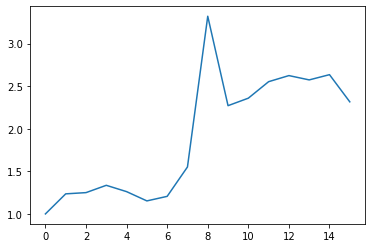

In [ ]:
plt.plot((micro.noise.theta_scale * micro.noise.theta_par).detach().cpu())

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *

num_iters = 300
batch_size = 50
i = 0

bce = torch.nn.BCEWithLogitsLoss()
mse = torch.nn.MSELoss()
opt = torch.optim.AdamW(net.parameters(), lr = 5e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.5)
loss_col = []

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate*2.,model.int_dist.int_conc, model.int_dist.int_rate, 
                                       model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds)).sample(from_code_book=True, phasing=True)
        xsim = micro(*sim_vars, add_noise=True)
        x = micro.noise(xsim, background, const_theta_sim=False).sample()

        gt_vars = sim_vars[:-1]
        gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

        model.eval().cuda()
        res_dict = model(x.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)

        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
    
    matches = matches.sample(frac=1).reset_index(drop=True)
        
    for b in range(len(matches)//batch_size):

        opt.zero_grad()

        net_inp = T(input_from_df(matches[b*batch_size:(b+1)*batch_size], True), dtype=torch.float32).cuda()
        
        net_out = net(net_inp)

        net_tar = T(target_from_matches(matches[b*batch_size:(b+1)*batch_size]), dtype=torch.float32).cuda()
        loss = bce(net_out, net_tar[:,None])
#         net_tar = T(verr_from_matches(matches[b*batch_size:(b+1)*batch_size]), dtype=torch.float32).cuda()
#         loss = mse(net_out, net_tar[:,None])
        
        loss.backward()
        
        opt.step()
        sched.step()
        
        loss_col.append(loss.item())

 23%|█████████████▊                                             | 70/300 [06:14<20:30,  5.35s/it]


KeyboardInterrupt: 

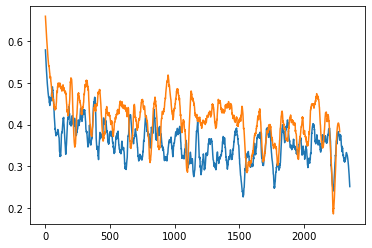

In [ ]:
from scipy.signal import savgol_filter

window = 51
order = 2
y_sf2 = savgol_filter(loss_col, window, order)
plt.plot(y_sf)
plt.plot(y_sf2)
plt.show()

In [ ]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
            print(p.split('/')[-1])
            img = load_tiff_image(p)[None]

            n_chans = img.shape[1]
            print(img.shape)
            z, y, x = img.shape[-3:]
                
            inp = img
#                 inp[:,1:] = torch.flip(inp[:,1:], dims=[4])
            output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            # output = model.cpu()(img[None,None])
            output = model.tensor_to_dict(output)
            p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            i_df = post_proc.get_df(output, p_si)
            print('N. emitters: ', len(i_df))
            i_df.loc[:,'frame_idx'] = 0
            pred_df = append_emitter_df(pred_df, i_df)
            free_mem()
        return pred_df

In [ ]:
image_paths = sorted(glob.glob(cfg.data_path.image_path))
inf_df = predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')

img_stack.tiff
torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  55404


In [ ]:
out_vals = []

for b in tqdm(range(len(inf_df)//100 + 1)):
    
    net_inp = T(input_from_df(inf_df[b*100:(b+1)*100], False), dtype=torch.float32).cuda()
    net_out = torch.sigmoid(net(net_inp))
#     net_out = net(net_inp)
    
    out_vals.append(np.array(cpu(net_out)))

100%|██████████████████████████████████████████████████████████| 555/555 [00:09<00:00, 59.34it/s]


In [ ]:
out_arr = np.concatenate(out_vals)
inf_df['net_qual'] = out_arr

(array([ 3727.,  3853.,  3598.,  3743.,  3663.,  3821.,  3834.,  3747.,
         4665., 20753.]),
 array([0.00220568, 0.10159906, 0.20099244, 0.3003858 , 0.3997792 ,
        0.49917257, 0.59856594, 0.6979593 , 0.79735273, 0.8967461 ,
        0.99613947], dtype=float32),
 <BarContainer object of 10 artists>)

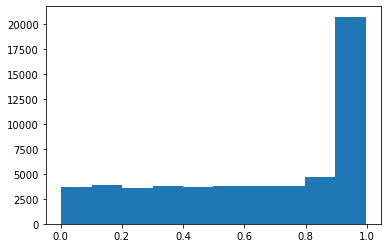

In [ ]:
plt.hist(inf_df['net_qual'])

In [ ]:
inf_df.to_csv(f'../data/results/MERFISH/{csv_name}.csv', index=False)

In [ ]:
from decode_fish.engine.point_process import *
num_iters = 20
i = 0

out_vals = []

df_col = []
pred_col = []

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate*2.,model.int_dist.int_conc, model.int_dist.int_rate, 
                                       model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds)).sample(from_code_book=True, phasing=True)
        xsim = micro(*sim_vars, add_noise=True)
        xsim = micro.noise(xsim, background).sample()

        gt_vars = sim_vars[:-1]
        gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

        model.eval().cuda()
        res_dict = model(xsim.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)

        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
    
    matches = matches.sample(frac=1).reset_index(drop=True)
        
    net_inp = T(input_from_df(matches, True), dtype=torch.float32).cuda()
    net_out = torch.sigmoid(net(net_inp))
#     matches[[f'bin_{i}' for i in range(16)]] = np.array(cpu(net_out))

#     net_out = net(net_inp)
    matches['net_qual'] = np.array(cpu(net_out))
    
    df_col.append(matches)
    pred_col.append(pred_df)
    
df_col = pd.concat(df_col)
df_col = df_col.reset_index()

pred_col = pd.concat(pred_col)
pred_col = pred_col.reset_index()

100%|████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.95s/it]


In [ ]:
res_df = df_col.copy()
res_df['comb_sig'] = np.sqrt(res_df['x_sig_pred']**2+res_df['y_sig_pred'])

int_keys = [f'int_{i}_tar' for i in range(16)]
int_pred = res_df[int_keys].values
s_arr = np.sort(int_pred)
lim = s_arr[:,-5]
tar_code = np.stack([np.where(i>l,1,0) for i,l in zip(int_pred, lim)])

code_ind = []

for i in tqdm(range(len(int_pred))):

    code_errors = vcorrcoef(code_ref, int_pred[i])
#     code_errors = bce_code(code_ref, int_pred[i])
    min_ind = np.argmin(code_errors)
    code_ind.append(min_ind)

res_df['gt_gene'] = targets[code_ind]

100%|████████████████████████████████████████████████████| 34624/34624 [00:04<00:00, 8502.87it/s]


In [ ]:
int_keys = [f'int_{i}_pred' for i in range(16)]
int_pred = res_df[int_keys].values

code_err = []
code_ind = []

for i in tqdm(range(len(int_pred))):

    code_errors = vcorrcoef(code_ref, int_pred[i])
#     code_errors = bce_code(code_ref, int_pred[i])
    min_ind = np.argmin(code_errors)
    code_err.append(code_errors[min_ind])
    code_ind.append(min_ind)

res_df['code_err'] = code_err
res_df['code_inds'] = code_ind
res_df['int_gene'] = targets[code_ind]

100%|████████████████████████████████████████████████████| 34624/34624 [00:03<00:00, 9672.71it/s]


In [ ]:
(res_df['gt_gene'] == res_df['int_gene']).sum()/len(res_df)

0.5835258780036968

In [ ]:
# (res_df['gt_gene'] == res_df['bin_gene']).sum()/len(res_df)

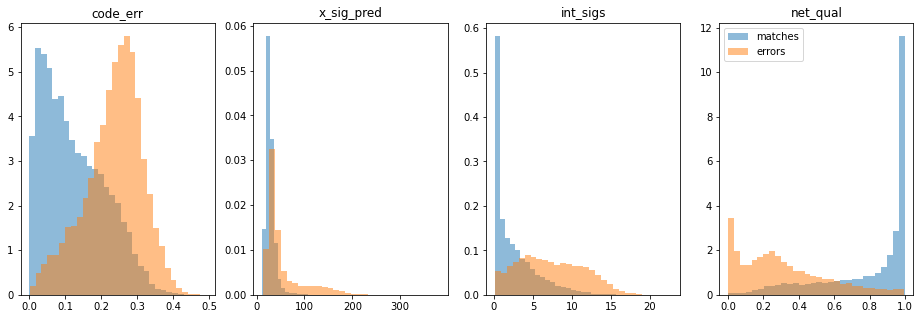

In [ ]:
res_df['int_sigs'] = res_df[[f'int_sig_{i}_pred' for i in range(16)]].values.sum(1)
res_df['ints'] = res_df[[f'int_{i}_pred' for i in range(16)]].values.sum(1)
metrics = ['code_err', 'x_sig_pred', 'int_sigs', 'net_qual']
plt.figure(figsize=(16,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[res_df['gt_gene'] == res_df['int_gene']][metrics[i]], density=True, alpha=0.5, bins=30, label='matches')
    _=plt.hist(res_df[res_df['gt_gene'] != res_df['int_gene']][metrics[i]], density=True, alpha=0.5, bins=30, label='errors')
    plt.title(metrics[i])
plt.legend()

In [ ]:
def make_roc(df, var='code_err', ascending=True):
    
    x = np.arange(1000,len(df),100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append(np.array([df[:int(i)]['gt_gene'] != df[:int(i)]['int_gene']]).sum())
        
    return x, n_blanks

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'code_err':[res_df, 'code_err', True],
            'int_sigs':[res_df, 'int_sigs', True],
            'net_qual':[res_df, 'net_qual', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

In [ ]:
# roc_dicts = roc_dict

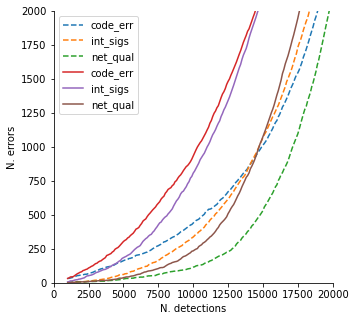

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
for k in roc_dicts:
    x, y = roc_dicts[k]
    plt.plot(x, y, label=k, linestyle='--')
    
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 2000)
plt.xlim(0, 20000)
plt.ylabel('N. errors')
plt.xlabel('N. detections')
sns.despine()

In [ ]:
# for k in inf_df.keys():
#     plt.figure(figsize=(15,10))
#     _ = plt.hist(inf_df[k], bins=51, alpha=0.5, density=True)
#     _ = plt.hist(pred_col[k], bins=51, alpha=0.5, density=True)
#     plt.title(k)
#     plt.show()